In [27]:
# v5: change hadcrut to C&W

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
import seaborn as sns

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [30]:
### set up and read in temp data

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10
temp_thresh = 1.5
#temp_thresh = 2

in_folder_tas = 'int_outputs/temperature_v2/'
#exp='ssp370'
exp='ssp245'
#exp='ssp126'
tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]
#tas_df.set_index('year',inplace=True)
print(tas_df['Model'].unique())
print(len(tas_df['Model'].unique()))


## observations
#Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'
#Hadcrut_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


['TaiESM1' 'AWI-CM-1-1-MR' 'MCM-UA-1-0' 'CIESM' 'SAM0-UNICON' 'NESM3'
 'GFDL-ESM4' 'GFDL-CM4' 'UKESM1-0-LL' 'KACE-1-0-G' 'NorESM2-MM'
 'NorESM2-LM' 'NorCPM1' 'CESM2-WACCM-FV2' 'CESM2-WACCM' 'CESM2-FV2'
 'CESM2' 'GISS-E2-2-H' 'GISS-E2-1-H' 'GISS-E2-1-G-CC' 'GISS-E2-1-G'
 'MRI-ESM2-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'UKESM1-1-LL'
 'HadGEM3-GC31-MM' 'HadGEM3-GC31-LL' 'MIROC6' 'MIROC-ES2L' 'MIROC-ES2H'
 'KIOST-ESM' 'IPSL-CM6A-LR-INCA' 'IPSL-CM6A-LR' 'IPSL-CM5A2-INCA'
 'INM-CM5-0' 'INM-CM4-8' 'MPI-ESM-1-2-HAM' 'FIO-ESM-2-0'
 'EC-Earth3-Veg-LR' 'BCC-CSM2-MR' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'FGOALS-f3-L'
 'FGOALS-g3' 'IITM-ESM' 'CanESM5' 'CanESM5-CanOE' 'CMCC-CM2-SR5'
 'CMCC-ESM2' 'CNRM-CM6-1' 'CNRM-CM6-1-HR' 'CNRM-ESM2-1' 'ACCESS-ESM1-5'
 'ACCESS-CM2' 'E3SM-1-1' 'EC-Earth3' 'EC-Earth3-CC' 'EC-Earth3-Veg']
58


In [31]:
tas_df

,year,no_arctic_tas,world_tas,Model,Experiment,Ensemble_member
3478,1850,288.220058,286.888552,TaiESM1,historical,r1i1p1f1
3479,1851,288.289197,287.017620,TaiESM1,historical,r1i1p1f1
3480,1852,288.311468,287.025041,TaiESM1,historical,r1i1p1f1
3481,1853,288.349248,287.044968,TaiESM1,historical,r1i1p1f1
3482,1854,288.381064,287.052927,TaiESM1,historical,r1i1p1f1
...,...,...,...,...,...,...
13368,2096,290.341155,289.413255,MCM-UA-1-0,ssp245,r1i1p1f2
13369,2097,289.981832,289.058426,MCM-UA-1-0,ssp245,r1i1p1f2
13370,2098,290.174832,289.264809,MCM-UA-1-0,ssp245,r1i1p1f2
13371,2099,290.556419,289.616816,MCM-UA-1-0,ssp245,r1i1p1f2


In [29]:
### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available

tas_df = tas_df.groupby(['year', 'Experiment', 'Model']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(models)
print(len(models))

['AWI-CM-1-1-MR' 'CESM2' 'CESM2-WACCM' 'CIESM' 'EC-Earth3-Veg-LR'
 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4' 'GISS-E2-1-G' 'HadGEM3-GC31-LL'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'KIOST-ESM'
 'MCM-UA-1-0' 'MIROC-ES2L' 'MIROC6' 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR'
 'MRI-ESM2-0' 'NESM3' 'NorESM2-LM' 'NorESM2-MM' 'TaiESM1' 'UKESM1-0-LL']
26


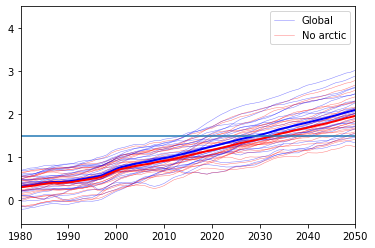

In [4]:
### initial basic plot, no correction to force realistic present temps

for model in models:
    df = tas_df[tas_df['Model']==model]
    plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=0.5, linewidth=0.5, label='Global')
    plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=0.5, linewidth=0.5, label='No arctic')

df = tas_df.groupby(['year']).mean().reset_index() 
plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=1, linewidth=2, label='Global')
plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=1, linewidth=2, label='No arctic')

legend_without_duplicate_labels(plt.gca())
plt.xlim(1980,2050)
plt.axhline(1.5)
plt.savefig('Figures/tas_anom_global_and_no_arctic.png', dpi=300)


In [5]:
#df= tas_df[tas_df['Experiment'] == exp]
df = tas_df.drop(columns=['Experiment'])
models = df['Model'].unique()
Model = []
No_arctic = []
World = []

for m in models:
    m_df = df[df['Model']==m]
    no_arctic_crossing_year = np.interp(temp_thresh, m_df['no_arctic_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    world_crossing_year = np.interp(temp_thresh, m_df['world_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    Model.append(m)
    No_arctic.append(np.round(no_arctic_crossing_year,3))
    World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
print('mean gap for crossing {}C: '.format(temp_thresh) + str(np.round(out_df['gap'].mean(), 2)))
#out_df.to_csv('Outputs/crossing_years.csv')
out_df

mean gap for crossing 1.5C: 3.57


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2024.194,2019.835,4.359
1,CESM2,2036.599,2031.641,4.958
2,CESM2-WACCM,2029.769,2027.225,2.544
3,CIESM,2014.664,2013.661,1.003
4,EC-Earth3-Veg-LR,2035.941,2026.083,9.858
5,FIO-ESM-2-0,2020.407,2017.602,2.805
6,GFDL-CM4,2036.399,2031.566,4.833
7,GFDL-ESM4,2050.706,2048.423,2.283
8,GISS-E2-1-G,2059.689,2055.529,4.160
9,HadGEM3-GC31-LL,2024.488,2022.222,2.266


observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278


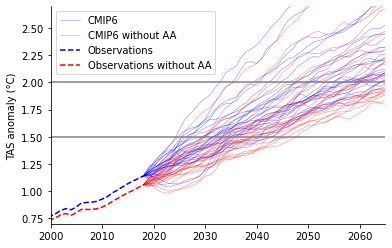

In [6]:
""" repeat, this time scaling temps to current observed warming """

global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])

Model = []
No_arctic = []
World = []
df_proj = tas_df
M_df = pd.DataFrame(columns=df.columns)

for m in models:

    m_df = df_proj[df_proj['Model']==m].copy()
    m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
    m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

    ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
    ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

    m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
    m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()

    m_df_plot = m_df[m_df['year'] >= obs_year]

    plt.plot(m_df_plot['year'], m_df_plot['adjusted_world_tas_anom'],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(m_df_plot['year'], m_df_plot['adjusted_no_arctic_tas_anom'], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')

#         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
    M_df = pd.concat([M_df,m_df],axis=1)

    #also calc crossings again
    no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
    world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

    Model.append(m)
    No_arctic.append(np.round(no_arctic_crossing_year,3))
    World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']

#mm_mean_df = out_df.groupby()

## add observations:
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')

legend_without_duplicate_labels(plt.gca())
plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Figures/tas_projections.png', dpi=300)

print('observation year: ' + str(obs_year))
print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))

In [7]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

In [8]:
mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
out_df

mean gap for crossing 1.5C: 4.64 +- 0.52 years


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2040.432,2035.125,5.307
1,CESM2,2030.084,2026.626,3.458
2,CESM2-WACCM,2035.742,2032.067,3.675
3,CIESM,2039.372,2031.492,7.880
4,EC-Earth3-Veg-LR,2044.850,2043.028,1.822
5,FIO-ESM-2-0,2037.829,2033.193,4.636
6,GFDL-CM4,2032.606,2026.246,6.360
7,GFDL-ESM4,2047.626,2038.944,8.682
8,GISS-E2-1-G,2030.006,2027.181,2.825
9,HadGEM3-GC31-LL,2029.540,2024.740,4.800


In [9]:
### now generate box plot by model (vertical), with multiple ensemble members for error bars

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()

#tas_df = tas_df[tas_df['Experiment'] != 'historical']
#tas_df = tas_df.drop(columns=['Experiment'])

#also calc crossings
Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']=='ssp245']['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e].copy()
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        except:
            print('error on: ' + m + e)
            
        me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
        me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

error on: E3SM-1-1r1i1p1f1


In [10]:
# ## plot
# sns.boxplot(data=out_df_ME, x='gap', y='Model', color='gray', showfliers = False)
# sns.stripplot(data=out_df_ME, x='gap', y='Model', color='black', marker='X')
# plt.ylabel('')
# plt.xlabel('Years later crossing {}°C'.format(temp_thresh))
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

# fig = plt.gcf()
# fig.set_size_inches(5, 8)
# plt.tight_layout()
# plt.savefig('Figures/crossing_years.png', dpi=300)

In [11]:
out_df_ME.dropna(inplace=True)

models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

# b, c = ensemble_members.loc[30], ensemble_members.loc[1]
# temp = ensemble_members.loc[30].copy()
# ensemble_members.loc[30] = c
# ensemble_members.loc[1] = temp
ensemble_members

,model,members
38,CanESM5,7.988
37,GFDL-ESM4,7.824
1,MPI-ESM1-2-LR,6.316
29,HadGEM3-GC31-LL,6.197
30,EC-Earth3,5.061
14,GISS-E2-1-G,4.776
18,ACCESS-ESM1-5,4.206
15,IPSL-CM6A-LR,4.138
6,NorESM2-LM,3.903
13,MIROC6,3.852


4.727333333333317


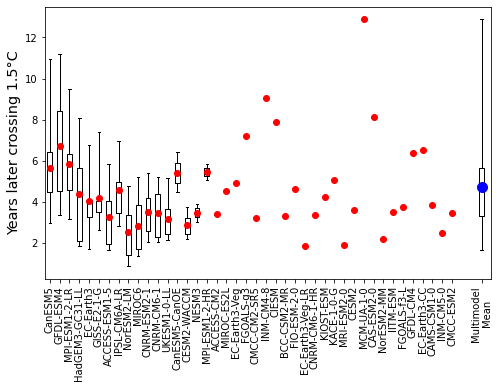

In [12]:
## plot

models = ensemble_members['model']

out_df_ME.dropna(inplace=True)

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]

means = np.array([list(v)[0] for v in vectors])


fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))

# for e, v in enumerate(vectors[:-1]):
#     ax.scatter(np.full(len(vers.loc[30].copy()
# ensemble_members.lo),e),v,color='k',s=8,zorder=10)
    
# ax.set_ylim(0,12)
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)

ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)

    
# print(np.nanmean(means))

ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')

# ax.xaxis.set_tick_params(rotation=90)
# # plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

# fig = plt.gcf()
# plt.tight_layout()
# plt.savefig('Figures/crossing_years_T.png', dpi=300)

plt.show()

4.727333333333317


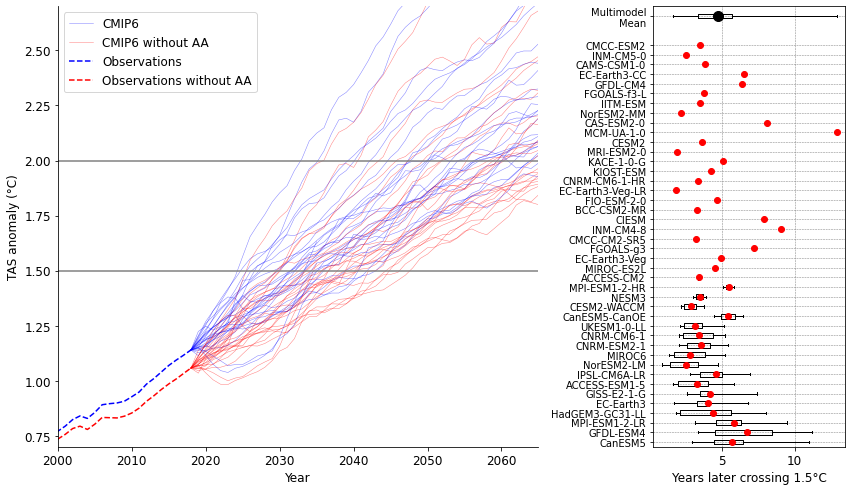

In [26]:
## combine both plots

models = ensemble_members['model']
out_df_ME.dropna(inplace=True)
vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

models_proj = df_proj['Model'].unique()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,7), gridspec_kw={'width_ratios': [2.5, 1]})
plt.rcParams['font.size'] = '12'

####### subplot 1

Model = []
No_arctic = []
World = []


for m in models_proj:
    m_df = df_proj[df_proj['Model']==m].copy()
    m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
    m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

    ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
    ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

    m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio_w).rolling(window, center=True).mean()
    m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio_na).rolling(window, center=True).mean()

    m_df_plot = m_df[m_df['year'] >= obs_year]

    ax1.plot(m_df_plot['year'], m_df_plot['adjusted_world_tas_anom'],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    ax1.plot(m_df_plot['year'], m_df_plot['adjusted_no_arctic_tas_anom'], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')

legend_without_duplicate_labels(ax1)
ax1.set_xlim(2000,2065)
ax1.set_ylim(0.7, 2.7)
ax1.axhline(2, color='gray')
ax1.axhline(1.5, color='gray')
ax1.set_ylabel('TAS anomaly (°C)')
ax1.set_xlabel('Year')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

####### subplot 2


ax2.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=False,
            meanprops={'marker':'o',
                       #'markersize':10,
              'markerfacecolor':'r',
              'markeredgecolor':'r'})
mm_shift = 2
ax2.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
print(np.nanmean(means))
# for e, v in enumerate(vectors[:-1]):
#     ax.scatter(np.full(len(vers.loc[30].copy()
# ensemble_members.lo),e),v,color='k',s=8,zorder=10)
    
# ax.set_ylim(0,12)
ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
# print(np.nanmean(means))
ax2.set_xlabel(f'Years later crossing {temp_thresh}°C')
# ax.xaxis.set_tick_params(rotation=90)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.set_yticklabels(list(models)+['Multimodel\nMean'],rotation=0, fontsize='small')  

# fig = plt.gcf()
plt.tight_layout()
plt.savefig('Figures/Combined.png', dpi=300)

plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(out_df_ME)
